In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import datetime as dt
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237d0058d88>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [10]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237d0077d48>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [12]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date > last_year).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index("date")

# Sort the dataframe by date
precip_sort = precip_df.sort_values("date")

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

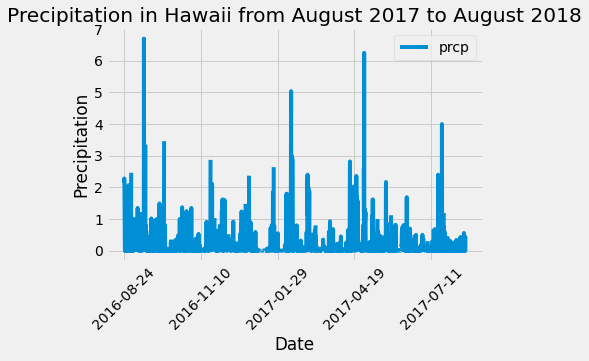

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_sort.plot()
plt.title("Precipitation in Hawaii from August 2017 to August 2018")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation='45')


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.id).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
                order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
high_low = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                        filter(measurement.station == "USC00519281").all()
print(high_low)

[(54.0, 85.0, 71.66378066378067)]


(array([55., 60., 65., 70., 75., 80., 85.]),
 <a list of 7 Text major ticklabel objects>)

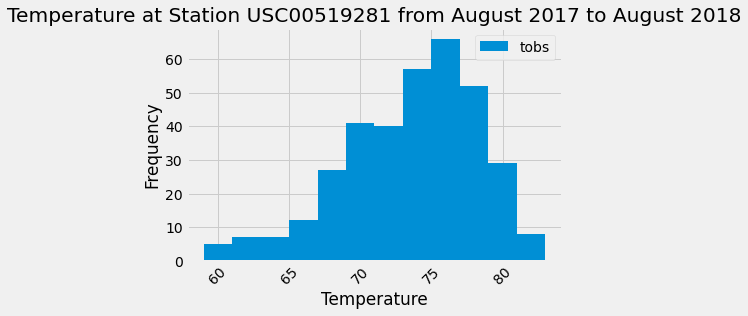

In [19]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).\
    filter(measurement.date > last_year).\
    filter(measurement.station == 'USC00519281').all()
temp_data

temp_data_df = pd.DataFrame(temp_data)

temp_data_df.plot.hist(bins=12)
plt.title("Temperature at Station USC00519281 from August 2017 to August 2018")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.xticks(rotation='45')


## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
session.query(measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs),
            func.max(measurement.tobs)).\
            filter(func.strftime("%Y-%m-%d", measurement.date) >=last_year).\
            group_by(measurement.date).all()

[('2016-08-23', 74.0, 78.28571428571429, 81.0),
 ('2016-08-24', 74.0, 77.57142857142857, 80.0),
 ('2016-08-25', 77.0, 79.42857142857143, 81.0),
 ('2016-08-26', 78.0, 80.5, 84.0),
 ('2016-08-27', 73.0, 76.83333333333333, 81.0),
 ('2016-08-28', 71.0, 76.0, 81.0),
 ('2016-08-29', 78.0, 78.71428571428571, 80.0),
 ('2016-08-30', 75.0, 77.33333333333333, 79.0),
 ('2016-08-31', 76.0, 78.28571428571429, 80.0),
 ('2016-09-01', 77.0, 80.16666666666667, 82.0),
 ('2016-09-02', 75.0, 79.42857142857143, 81.0),
 ('2016-09-03', 75.0, 77.4, 79.0),
 ('2016-09-04', 73.0, 77.0, 84.0),
 ('2016-09-05', 76.0, 79.5, 84.0),
 ('2016-09-06', 73.0, 75.66666666666667, 80.0),
 ('2016-09-07', 74.0, 75.83333333333333, 80.0),
 ('2016-09-08', 74.0, 78.71428571428571, 81.0),
 ('2016-09-09', 75.0, 77.42857142857143, 79.0),
 ('2016-09-10', 75.0, 76.8, 78.0),
 ('2016-09-11', 71.0, 77.2, 83.0),
 ('2016-09-12', 72.0, 76.85714285714286, 79.0),
 ('2016-09-13', 75.0, 77.57142857142857, 79.0),
 ('2016-09-14', 73.0, 75.8571428571

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
